In [2]:
import sys
import os.path as op
from glob import glob
import shutil
import warnings
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import nibabel as nib

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

sys.path.append("/Users/dschonhaut/code/style")
from colors import get_colors
co, palettes = get_colors()

sys.path.append("/Users/dschonhaut/code")
from general.array import array_operations as aop
from general.basic.helper_funcs import *
from general.basic.str_methods import *
import general.nifti.nifti_ops as nops
import general.nifti.nifti_plotting as niiplot

%matplotlib inline
mpl.rcParams['font.sans-serif'] = "Helvetica"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["xtick.major.width"] = 0.8
mpl.rcParams["ytick.major.width"] = 0.8
colors = [
    "2E45B8",
    "F97A1F",
    "3EBCD2",
    "FF4983",
    "1DC9A4",
    "B38FE7",
    "F9C31F",
    "E3120B",
]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelpad"] = 8
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.subplot.wspace"] = 0.25
mpl.rcParams["figure.subplot.hspace"] = 0.25
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["pdf.fonttype"] = 42
font = {"tick": 6, "label": 7, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 6.45}

In [3]:
def fmt_date(year, month, day):
    """Format date from numeric year, month, day and return the date."""
    try:
        outdate = datetime.date(
            year=int(float(year)), month=int(float(month)), day=int(float(day))
        )
        return outdate
    except ValueError:
        return None


def fmt_datetime(string, fmt="%Y-%m-%d %H:%M:%S.%f"):
    """Format a datetime string and return the date."""
    try:
        outdate = datetime.datetime.strptime(string, fmt).date()
        return outdate
    except ValueError:
        return None


def baseline_date(df, date_col, subj):
    """Return the baseline date for a given subject.

    df must have columns 'subj' and 'visit', and the baseline visit must
    be coded as 1.
    """
    assert np.min(df["visit"]) == 1
    return df.loc[(df["subj"] == subj) & (df["visit"] == 1), date_col].iloc[0]


def date_diff(date1, date2, abs=False):
    """Return date2 - date1 in years."""
    try:
        diff = (date2 - date1).days / 365.25
        if abs:
            return np.abs(diff)
        else:
            return diff
    except TypeError:
        return None


def _quartiles(x):
    return quartiles(x, decimals=0)


def map_fsroi(hem, fsroi):
    """Map fsrois label to suvr and vol cols in the ready_dataset df."""
    suvr_suffix = "_MRIBASED_SUVR"
    vol_suffix = "_ClustSize"

    if fsroi.lower() == "amygdala":
        if hem.lower() == "l":
            hemout = "Left"
        elif hem.lower() == "r":
            hemout = "Right"
        else:
            raise ValueError(f"hemisphere must be 'L' or 'R', not {hem}")
        roiout = "Amygdala"
        hemroiout = f"{hemout}_{roiout}"
    else:
        if hem.lower() == "l":
            hemout = "lh"
        elif hem.lower() == "r":
            hemout = "rh"
        else:
            raise ValueError(f"hemisphere must be 'L' or 'R', not {hem}")
        roiout = fsroi
        hemroiout = f"ctx_{hemout}_{roiout}"

    suvr_col = f"{hemroiout}{suvr_suffix}"
    vol_col = f"{hemroiout}{vol_suffix}"
    return suvr_col, vol_col


def weighted_suvr(values, mean_cols, vol_cols):
    """Calculate weighted mean SUVR and sum volume across regions.

    The regions contained in `mean_cols` and `vol_cols` are assumed to
    match each other in order, i.e., the first region in `mean_cols`
    corresponds to the first region in `vol_cols`. These regions are
    aggregated into a single, larger region for which the weighted mean
    SUVR and sum volume is calculated for each row of `values`.

    Parameters
    ----------
    values : pd.DataFrame
        Dataframe whose rows comprise individual PET scans and whose
        columns include regional mean ROIs and corresponding regional
        volumes.
    mean_cols : list of str
        List of columns with mean SUVR values.
    vol_cols : list of str
        List of columns with corresponding volume values.

    Returns
    -------
    means : list of float
        List of weighted mean SUVR values for each row in `values`.
    volumes : list of float
        List of sum of volumes for each row in `values`.
    """
    means, volumes = zip(
        *values.apply(
            lambda x: (
                np.average(x[mean_cols], weights=x[vol_cols]),
                np.sum(x[vol_cols]),
            ),
            axis=1,
        )
    )
    return means, volumes

In [4]:
# Import the data.
proj_dir = op.join(op.expanduser("~"), "box/projects/leads_tau_spread")
proc_date = "2023-09-15"
cl_thresh = 25
antiamy_subjs = [
    "LDS0360378",
    "LDS9410139",
    "LDS9410287",
    "LDS9410376",
    "LDS9410396",
    "LDS9410450",
    "LDS9410459",
]

# ------------------------------------
# Get paths to relevant directories.
ssheet_dir = op.join(proj_dir, "data", "ssheets")
loni_dir = op.join(ssheet_dir, "loni", f"download_{proc_date}")
fig_dir = op.join(proj_dir, "figs")

# Load fsrois.
fsrois = pd.read_csv(op.join(ssheet_dir, "fsrois.csv"))
fsrois["leads_suvr"], fsrois["leads_vol"] = zip(
    *fsrois.apply(lambda x: map_fsroi(x["hem"], x["fsroi"]), axis=1)
)

print(f"fsrois: {fsrois.shape}")

fsrois: (70, 20)


In [58]:
# Import the formatted ROI dataframes
tau_eoad = pd.read_csv(
    op.join(ssheet_dir, "tau-roi24-mems_all-eoad-gt1ftp_2023-09-18.csv")
)

print(f"tau_eoad: {tau_eoad.shape}")

tau_eoad: (4008, 18)


In [62]:
(
    tau_eoad.drop_duplicates("subj")
    .groupby("roi")
    .agg(
        {
            "subj": "count",
            "ftp_visits": mean_sd,
            "ftp_yrs_from_bl": mean_sd,
            "sex": count_unique,
            "age_at_ftp_bl": mean_sd,
            "apoe4_alleles": count_unique,
            "fbb_cl_bl": mean_sd,
            "mmse_bl": mean_sd,
            "cdr_sb_bl": mean_sd,
        }
    )
    .rename(
        columns={
            "subj": "# Subjects",
            "age_at_ftp_bl": "Age at BL",
            "sex": "Sex",
            "ftp_visits": "# Visits",
            "ftp_yrs_from_bl": "Max. Yrs. Follow-up",
            "apoe4_alleles": "APOE4 Alleles",
            "fbb_cl_bl": "FBB CL at BL",
            "mmse_bl": "MMSE at BL",
            "cdr_sb_bl": "CDR-SB at BL",
        }
    )
    .reset_index(drop=True)
    .T.rename(columns={0: "EOAD"})
)

,EOAD
# Subjects,167
# Visits,2.46 ± 0.67
Max. Yrs. Follow-up,1.84 ± 0.86
Sex,"f: 94, m: 73"
Age at BL,59.32 ± 4.05
APOE4 Alleles,"0.0: 74, 1.0: 64, 2.0: 20, nan: 9"
FBB CL at BL,95.86 ± 25.93
MMSE at BL,21.82 ± 4.99
CDR-SB at BL,3.70 ± 1.68


In [59]:
tau_eoad.columns

Index(['subj', 'roi', 'parc', 'dx', 'age_at_ftp_bl', 'sex', 'ftp_visits',
       'ftp_yrs_from_bl', 'apoe4_alleles', 'fbb_cl_bl', 'mmse_bl', 'cdr_sb_bl',
       'icpt', 'slope', 'fixed_icpt', 'fixed_slope_time', 'rndm_icpt',
       'rndm_slope_time'],
      dtype='object')

In [78]:
roi_dat = (
    tau_eoad.groupby("roi")
    .agg(
        {
            "fixed_icpt": lambda x: np.unique(x)[0],
            "fixed_slope_time": lambda x: np.unique(x)[0],
        }
    )
    .rename(columns={"fixed_icpt": "icpt", "fixed_slope_time": "slope"})
    .reset_index()
)
roi_dat

,roi,icpt,slope
0,acc,1.281998,0.046533
1,amy,1.743659,0.035973
2,cun,1.788063,0.092137
3,erc,1.711004,0.038849
4,fsf,2.070186,0.091529
5,ifg,1.789882,0.102419
6,ins,1.410523,0.051217
7,ipc,2.525456,0.064634
8,itg,2.249426,0.095879
9,ling,1.684638,0.082271


/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_30254/2554443951.py:40: UserWarning: The palette list has more values (24) than needed (6), which may not be intended.
  sns.scatterplot(
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_30254/2554443951.py:97: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


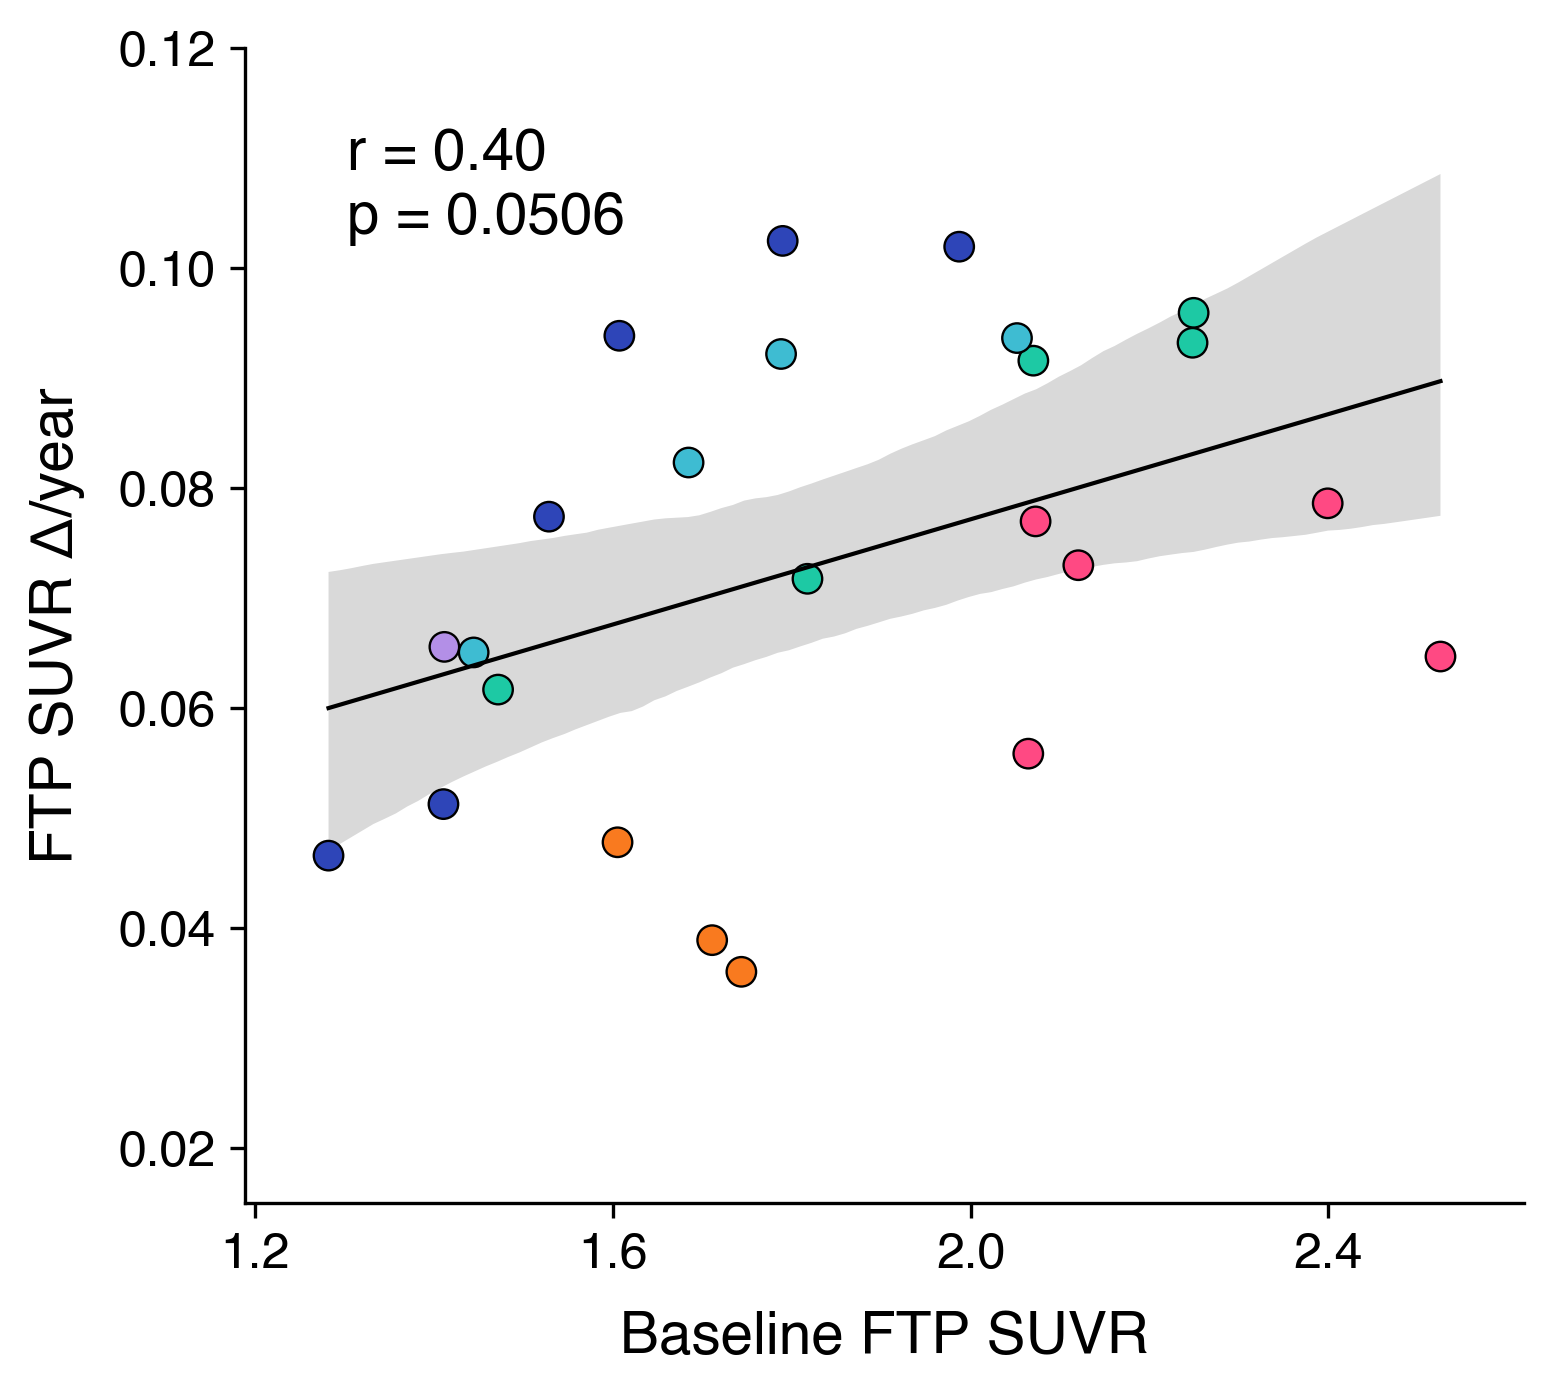

In [77]:
_dat = roi_dat.copy()
show_legend = False

# --------------------------------
roi_map = (
    fsrois[["roi24", "lobe6"]].drop_duplicates().set_index("roi24")["lobe6"].to_dict()
)
_dat["lobe"] = _dat["roi"].map(roi_map)

# Create boxplots with scatter points overlaid in seaborn.
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
xcol = "icpt"
ycol = "slope"
xmin = _dat[xcol].min() - (np.ptp(_dat[xcol]) * 0.075)
xmax = _dat[xcol].max() + (np.ptp(_dat[xcol]) * 0.075)
ymin = 0.015  # _dat[ycol].min() - (np.ptp(_dat[ycol]) * 0.075)
ymax = 0.12  # _dat[ycol].max() + (np.ptp(_dat[ycol]) * 0.075)

# Add line of best fit.
sns.regplot(
    x=xcol,
    y=ycol,
    data=_dat,
    ax=_ax,
    fit_reg=True,
    ci=95,
    truncate=True,
    scatter_kws={
        "s": 0,
    },
    line_kws={"color": "k", "linewidth": 1},
)

# Add the scatter points.
_ax.axvline(x=0, lw=1, zorder=0, color=co["p2"])
sns.scatterplot(
    x=xcol,
    y=ycol,
    data=_dat,
    ax=_ax,
    s=50,
    hue="lobe",
    palette=palettes["pal24"],
    edgecolor="k",
    hue_order=["Frontal", "MTL", "Occipital", "Parietal", "Temporal", "Sensorimotor"],
)

r, p = stats.pearsonr(_dat[xcol], _dat[ycol])
# r, p = stats.spearmanr(_dat[xcol], _dat[ycol])
fit = sm.OLS(_dat[ycol], sm.add_constant(_dat[xcol])).fit().predict()
_dat["fit"] = fit
if p < 0.0001:
    msg = "r = {:.2f}\np < 0.0001".format(r)
else:
    msg = "r = {:.2f}\np = {:.4f}".format(r, p)

_ax.text(
    0.08,
    0.88,
    msg,
    transform=_ax.transAxes,
    ha="left",
    va="center",
    color=co["k"],
    fontsize=14,
)
# _ax.plot(_dat.sort_values(xcol)[xcol], _dat.sort_values(xcol)["fit"],
#          color="k", lw=1)

_ax.set_xlim([xmin, xmax])
_ax.set_ylim([ymin, ymax])
# _ax.set_aspect(np.ptp(_dat[xcol]) / np.ptp(_dat[ycol]))
_ax.set_xticks(np.arange(1.2, 2.6, 0.4))
_ax.set_yticks(np.arange(0.02, 0.121, 0.02))
_ax.set_xlabel("Baseline FTP SUVR")
_ax.set_ylabel("FTP SUVR Δ/year")

# get the legend and format it
handles, labels = _ax.get_legend_handles_labels()
if show_legend:
    legend = _ax.legend(
        handles=handles,
        labels=labels,
        markerscale=3,
        loc="upper right",
        bbox_to_anchor=(1.4, 0.47),
        frameon=False,
    )
else:
    _ax.get_legend().remove()

fig.set_size_inches(5.5, 5)
fig.show()